In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pmdarima as pm 
from pmdarima import model_selection 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from math import sqrt 
import pmdarima as pm 
from pmdarima import model_selection 
import statsmodels.api as sm 

# Data management

In [45]:
file_P = os.path.join(os.getcwd(),'Elspotprices2.csv')
df_prices = pd.read_csv(file_P)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
df_prices = df_prices.loc[(df_prices['PriceArea']=="DK2")][["HourUTC","SpotPriceDKK"]]
df_prices = df_prices.loc[df_prices["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_prices = df_prices.reset_index(drop=True)

file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])
df_data = df_data.loc[df_data["HourUTC"].dt.year.isin([2019,2020,2021,2022,2023])]
df_data = df_data.reset_index(drop=True)

# Convert the 'HourUTC' column to datetime if it's not already
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])

# Set the start and end dates
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2023-11-30')

# Filter the data and reset indec
df_prices = df_prices[(df_prices['HourUTC'] >= start_date) & (df_prices['HourUTC'] <= end_date)]
df_prices = df_prices.reset_index(drop=True)

# Split data into training and testing sets
data = df_prices[(df_prices['HourUTC'].dt.date >= start_date.date()) & (df_prices['HourUTC'].dt.date <= end_date.date())]
data = data['SpotPriceDKK'].values
train, test = model_selection.train_test_split(data, test_size=744)



# Plots

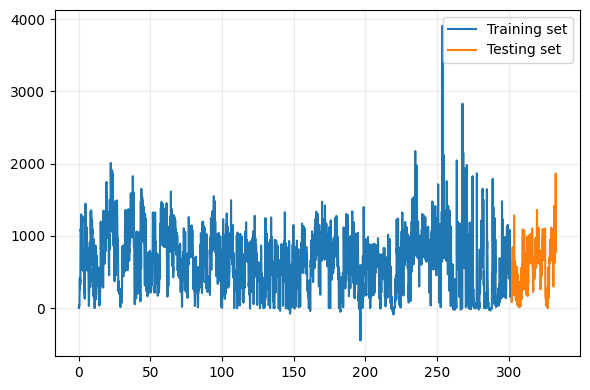

744
7249


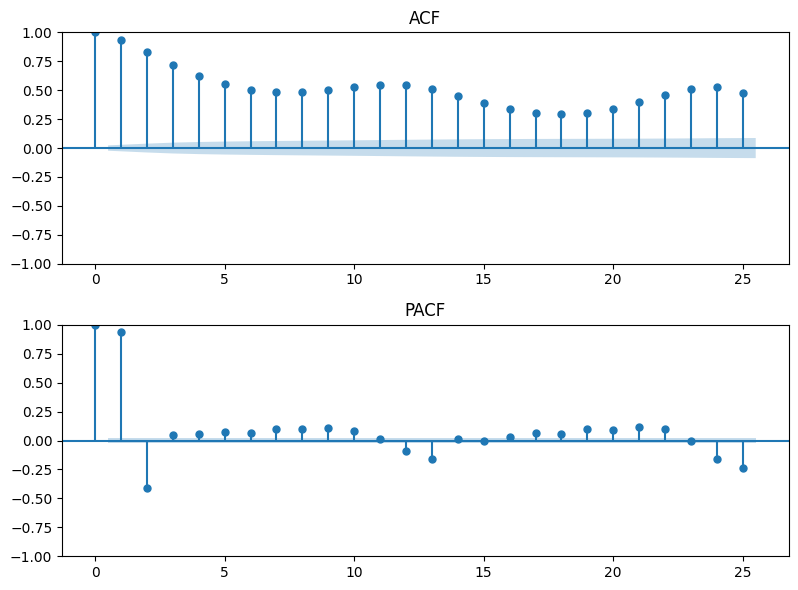

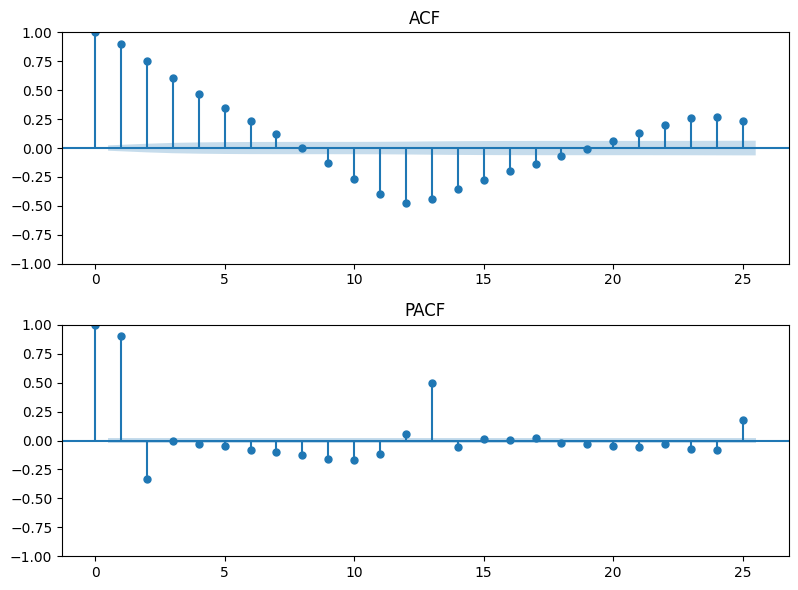

In [46]:
n_train = len(train)
n_test = len(test)
n_data = len(data)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(1,n_train+1)/24, train)
plt.plot(np.arange(n_train+1,n_data+1)/24, test)
plt.legend(["Training set", "Testing set"])
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


print(n_test)
print(n_train)



# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Check ACF plot
sm.graphics.tsa.plot_acf(train, title = "ACF", lags=25, ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(train, title = "PACF", lags=25, ax=ax[1])

plt.tight_layout()
plt.show()
# from the previously plot a seasonal pattern is observed, thus we will take the difference of the data with a lag of 12
train12 = pm.utils.diff(train,12)

# Plot ACF/PACF plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Check ACF plot
sm.graphics.tsa.plot_acf(train12, lags=25, title="ACF", ax=ax[0])

# Check the PACF plot
sm.graphics.tsa.plot_pacf(train12, lags=25, title="PACF", ax=ax[1])

plt.tight_layout()
plt.show()

# Arima

In [47]:
# Create Arima models with and without seasonality


m_noS = pm.auto_arima(train, trace = True, seasonal = False)
m_S = pm.auto_arima(train, trace = True, seasonal=True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=89604.642, Time=5.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=91314.809, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90288.151, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=90270.829, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91312.810, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=89618.027, Time=4.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=89621.711, Time=3.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=89593.957, Time=5.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=89718.728, Time=3.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=89595.889, Time=6.42 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=89596.179, Time=7.66 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=89653.007, Time=2.93 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=89597.527, Time=6.18 sec
 ARIMA(2,1,3)(0,0,0)[0]  

# Forecast

In [5]:
print(len(data))
print(len(test))
print(len(train))

print(data)

1441
744
697
[660.86 599.84 648.1  ... 851.95 781.31 779.3 ]


In [48]:
### 1-day predictions ###

# Create an empty list for the day ahead forecasts
Forecasts_S = []
Forecasts_noS = []
Persistence = []
N = int(len(test)/24)
for i in range(N):

    # Generate forecast for the next time step
    frc_S   = m_S.predict(n_periods=24)
    frc_noS = m_noS.predict(n_periods=24)
    
    # Append the forecast to the list
    Forecasts_S.extend(frc_S)
    Forecasts_noS.extend(frc_noS)
    
    Persistence.extend(data[len(train)+i*24-24:len(train)+i*24])
    
    # Update the model with new observations
    m_S.update(test[i])
    m_noS.update(test[i])
    print(i)
    

    




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


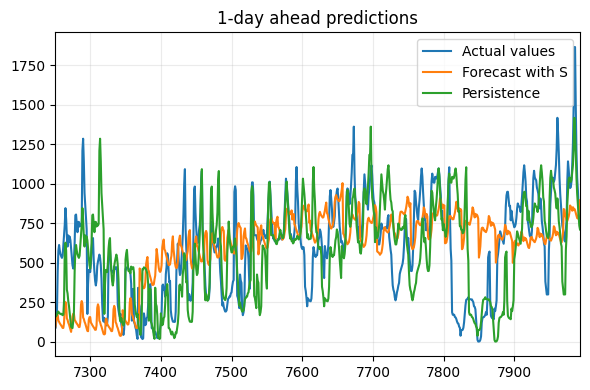

In [59]:
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(n_train+1,n_data+1), test)
plt.plot(np.arange(n_train+1,n_train+1+len(Forecasts_S)), Forecasts_S)
plt.plot(np.arange(n_train+1,n_data+1), Persistence)
plt.title("1-day ahead predictions")
plt.legend(["Actual values", "Forecast with S", "Persistence"])
plt.xlim(n_train+1, n_data)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()